# Knowledge graph embedding as learning a functor



Initialise entities (nouns) and relations (verbs).

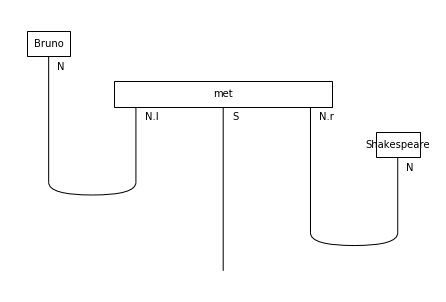

In [1]:
from discopy.rigid import Ty, Id, Box, Diagram

n, s = Ty('N'), Ty('S')

make_word = lambda name, ty: Box(name, Ty(), ty)
nouns = [make_word(name, n) for name in ['Bruno', 'Florio', 'Shakespeare']]
verbs = [make_word(name, n.l @ s @ n.r) for name in ['met', 'read']]

grammar = Diagram.cups(n, n.l) @ Id(s) @ Diagram.cups(n.r, n)
sentences = [a @ b @ c >> grammar for a in nouns for b in verbs for c in nouns]
sentences[2].draw()

### Build a tensor.Functor representing the true state

In [2]:
from discopy.tensor import Dim, Tensor, Functor
import numpy
import jax.numpy as np
Tensor.np = np

ob = {n: Dim(3), s: Dim(1)}
def mapping(box):
    if box.name == 'Bruno':
        return np.array([1, 0, 0])
    if box.name == 'Florio':
        return np.array([0, 1, 0])
    if box.name == 'Shakespeare':
        return np.array([0, 0, 1])
    if box.name == 'met':
        return np.array([[1, 0, 1], [0, 1, 1], [1, 1, 1]])
    if box.name == 'read':
        return np.array([[1, 0, 0], [0, 1, 1], [0, 1, 1]])

T = Functor(ob, mapping)
T(sentences[8])

Tensor(dom=Dim(1), cod=Dim(1), array=[1.])

### Parametrise a tensor.Functor 

In [3]:
def p_mapping(box, params):
    if box.name == 'Bruno':
        return np.array(params[0])
    if box.name == 'Florio':
        return np.array(params[1])
    if box.name == 'Shakespeare':
        return np.array(params[2])
    if box.name == 'met':
        return np.array([params[3], params[4]])
    if box.name == 'read':
        return np.array([params[5], params[6]])

ob = {n: Dim(2), s: Dim(1)}
F = lambda params: Functor(ob, lambda box: p_mapping(box, params))
params0 = numpy.random.rand(6, 2)
F(params0)(sentences[8])

Tensor(dom=Dim(1), cod=Dim(1), array=[1.13699007])

The loss of a functor is the mean-squared difference with the true labels of sentences.

In [4]:
from jax import grad
def sigmoid(x):
    sig = 1 / (1 + np.exp(-x))
    return sig

evaluate = lambda F, sentence: sigmoid(F(sentence).array)

def mean_squared(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

loss = lambda params: mean_squared(*zip(*[(T(sentence).array, evaluate(F(params), sentence))
                                          for sentence in sentences]))

grad(loss)(params0)

DeviceArray([[ 0.0223022 ,  0.04048583],
             [-0.00051931,  0.0002769 ],
             [-0.01686063, -0.03567511],
             [-0.00315822, -0.00554015],
             [-0.00553753, -0.00982708],
             [ 0.00240619,  0.00503511]], dtype=float32)

Define gradient descent update function.

In [5]:
from jax import jit

step_size = 0.1

@jit
def update(params):
    return params - step_size * grad(loss)(params)

jit(update)

<function __main__.update(params)>

Run a learning loop

In [6]:
from time import time

epochs, iterations = 7, 30
params = numpy.random.rand(6, 2)
for epoch in range(epochs):
    start = time()
    for i in range(iterations):
        params = update(params)

    print("Epoch {} ({:.3f} milliseconds)".format(epoch, 1e3 * (time() - start)))
    print("Testing loss: {:.5f}".format(loss(params)))

Epoch 0 (9805.920 milliseconds)
Testing loss: 0.24202
Epoch 1 (3.831 milliseconds)
Testing loss: 0.23085
Epoch 2 (2.954 milliseconds)
Testing loss: 0.21644
Epoch 3 (4.268 milliseconds)
Testing loss: 0.19732
Epoch 4 (4.201 milliseconds)
Testing loss: 0.17301
Epoch 5 (2.780 milliseconds)
Testing loss: 0.14514
Epoch 6 (2.588 milliseconds)
Testing loss: 0.11930


In [7]:
final_params = params

In [8]:
from sklearn.metrics import classification_report

y_true = [T(sentence).array for sentence in sentences]
y_pred = [0 if evaluate(F(final_params), sentence) < 0.5 else 1 for sentence in sentences]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         6
         1.0       1.00      0.83      0.91        12

    accuracy                           0.89        18
   macro avg       0.88      0.92      0.88        18
weighted avg       0.92      0.89      0.89        18



In [9]:
evaluate(F(final_params), sentences[2])

DeviceArray(0.4077197, dtype=float32)